# Load prior saved versions of x,y datasets below while updates in progress for building datasets code

#### GRID SEARCHES AND TIME CONSUMING ALGORITHM'S ARE CURRENTLY TRAINED ON A 10,000 INSTANCE SUBSET FOR NOW

# Summary of Results

,Models,Scores
0,ADA Boost,2.19
1,Baseline Guesser,1.75
2,K-Neighbors,1.69
3,Random Forest,1.63
4,Logistic Regression,1.62
5,XGBoost,1.61
6,Gradient Boosting,1.60
7,Neural Network,1.59


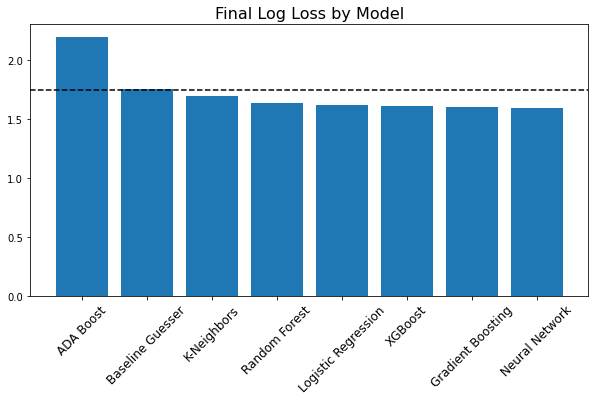

In [426]:
plt.figure(figsize = (10,5))
plt.bar(summary_df.Models, summary_df.Scores)
plt.xticks(rotation=45)
plt.xticks(fontsize = 12)
plt.axhline(y = -model_summary["Baseline Guesser"]["Score"], color = 'k', linestyle = 'dashed')     
plt.title("Final Log Loss by Model", fontsize=16)
summary_df[["Models", "Scores"]]

In [155]:
import pandas as pd
import numpy as np
import pickle as pkl
import random
import time
import math
import pybaseball
import sklearn
import itertools
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, cross_validate, cross_val_predict, GridSearchCV
import matplotlib.pyplot as plt
from pybaseball import playerid_lookup, playerid_reverse_lookup
import warnings
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.exceptions import ConvergenceWarning

#from ipynb.fs.full.Building_Dataset_Functions import * 

hand_combos = ["RR", "RL", "LR", "LL"]
training_years = ["2012", "2013", "2014"]


warnings.simplefilter("ignore")


[CV] END ............................... score: (test=-1.595) total time= 2.4min
[CV] END ............................... score: (test=-1.593) total time= 2.4min
[CV] END ............................... score: (test=-1.594) total time= 2.5min


In [2]:
X = pkl.load(open("ML X Dataset", "rb"))
Y_play = pkl.load(open("ML Y Dataset (Plays)", "rb"))
Y_onbase = pkl.load(open("ML Y Dataset (On Base)", "rb"))

In [3]:
plays = [play for play in Y_play.value_counts().index]

### Odds Functions

In [4]:
def log5 (pB, pP, pL):
    """ Given the probability of a PA outcome for the pitcher, the batter, and the overall league, calculate the
    probability in that given at bat using the log5 equation. NOTE: DO NOT USE RIGHT NOW""" 
    one = (pB*pP)/pL
    two = ((1-pB)*(1-pP))/(1-pL)
    
    return one/(one + two)


def morey_z(pB, pP, pL):
    """ Given the probability of a PA outcome for the pitcher, the batter, and the overall league, calculate the
    probability in that given at bat using the Morey Z equation"""
    one = (pB-pL)/np.sqrt(pL*(1-pL))
    two = (pP-pL)/np.sqrt(pL*(1-pL))
    three = np.sqrt(pL*(1-pL))
    return ((one + two)/np.sqrt(2) * three) +pL

def ab_play_percentages(batting_percentages, pitching_percentages, league_percentages, pitbat_combo, function):
    """ Given a list of probabilities for all PA outcomes for the batter, the pitcher, and the league, along with
    the pitbat combo, and the desired probability funtion, return a list of the probabilities for all PA outcomes 
    for the specific PA"""
    
    ab_percentages = {}
    
    # Get the specific percentages for each play type
    for play in plays:
        batting_percent = batting_percentages["b_" + play]
        pitching_percent = pitching_percentages["p_" + play]
        league_percent = league_percentages[pitbat_combo][play]
        
        # Ensure we are using one of the two acceptable prediction functions
        if function not in ["morey z", "Morey Z", "log5", "Log5"]:
            while funtion not in ["morey z", "Morey Z", "log5", "Log5"]:
                function = input("Acceptable Functions are Morey Z and Log5. Please input one.")
        
        # Calculate the predicted percentage for the specific play for the PA
        if function == "morey z" or function == "Morey Z":
            expected_percent = max(morey_z(batting_percent, pitching_percent, league_percent), 0.000001)
        else:
            expected_percent = log5(batting_percent, pitching_percent, league_percent)
    
        # Insert the predicted percentage for the play type into our dictionary for delivery
        ab_percentages[play] = expected_percent
        
        # Get rid of negative and zero numbers and repercenage slightly if numbers are reset
        ab_percentages = {key: value/sum(list(ab_percentages.values())) for key, value in ab_percentages.items()}
    
    return ab_percentages

# League Average Guesser
def average_guesser(batting_percentages, pitching_percentages, league_percentages, pitbat_combo):
    ab_percentages = {}
    
    for play in plays:
        league_percent = league_percentages[pitbat_combo][play]
        ab_percentages[play] = league_percent
        
    ab_percentages = {key: value/sum(list(ab_percentages.values())) for key, value in ab_percentages.items()}
    
    return ab_percentages  
        

In [5]:
def log_loss(probabilities, actuals):
    """ Given a list of probabilities and acuals for a series of instances, calculate and return the average log loss"""
    log_loss = 0
    yhat_probabilities = []
    for instance in range(len(probabilities)):
        yhat_probabilities.append(max([n for n in np.array(probabilities.iloc[instance])*np.array(actuals.iloc[instance])]))
    log_loss -= sum([np.log10(x)for x in yhat_probabilities])


    return log_loss/len(probabilities)

In [197]:
def plot_model_error_on_n(model, n1, n2, model_name = "The Model", x_train=x_train, y_train=y_train):
    score_dict = {}
    for n in [x for x in range (n1,n2+1000) if x%1000==0]:
        print("Training Model on {} Instances".format(n))
        score = cross_val_score(model, x_train[:n], y_train[:n], cv=5, scoring="neg_log_loss", verbose=3, error_score="raise")
        score_dict[n] = -score.mean()
        clear_output(wait=False)
    plt.plot(score_dict.keys(), score_dict.values())
    plt.title("{} Log Loss With Sample Size n".format(model_name))

In [6]:
league_averages = pkl.load(open("league_averages.pkl", "rb"))

# ML Algorithms

In [14]:
# x_train, x_test, y_train, y_test = train_test_split(ml_full_df, y_full, test_size=0.2, random_state=42)
sss = StratifiedShuffleSplit(test_size=.2, random_state=42)
for train_index, test_index in sss.split(X, Y_play):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y_play[train_index], Y_play[test_index]
    y_train_onbase, y_test_onbase = Y_onbase[train_index], Y_onbase[test_index]

## Poor Average Estimator

In [20]:
dumb_log_loss_plays = 0
league_averages_plays = {}
for play in y_train.value_counts().index:
    league_averages_plays[play] = len(y_train[y_train == play])/len(y_train)
    dumb_log_loss_plays += len(y_train[y_train == play])/len(y_train)* np.log(len(y_train[y_train == play])/len(y_train))
    
    
dumb_log_loss_onbase = 0
league_averages_onbase = {}
for play in y_train_onbase.value_counts().index:
    league_averages_onbase[play] = len(y_train_onbase[y_train_onbase == play])/len(y_train_onbase)
    dumb_log_loss_onbase += len(y_train_onbase[y_train_onbase == play])/len(y_train_onbase)* np.log(len(y_train_onbase[y_train_onbase == play])/len(y_train_onbase))
    
print("The Crappy Average Estimator for Predicting Plays Has a Neg Log Loss of: {}".format(round(dumb_log_loss_plays,3)))
#print("The Crappy Average Estimator for Predicting On Base Has a Neg Log Loss of: {}".format(round(dumb_log_loss_onbase,3)))

The Crappy Average Estimator for Predicting Plays Has a Neg Log Loss of: -1.745


## Regressions

### Basic Logistic Regresssion

In [19]:
# Set up a logistic regression on the full x,y train datasets and check the baseline log_loss
softmax = LogisticRegression(class_weight = None, max_iter=150)
softmax_scores = cross_val_score(softmax, x_train[:], y_train[:], cv=5, scoring = "neg_log_loss", n_jobs=4)
clear_output(wait=False)
print("The Basic Logistic Regressor Has a Neg Log Loss of: {}".format(round(softmax_scores.mean(),3)))

The Basic Logistic Regressor Has a Neg Log Loss of: -1.621


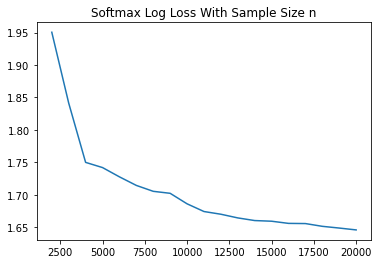

In [49]:
# Check approx where softmax error starts to plateau based on n instances for cutting off grid search
plot_model_error_on_n(softmax, 2000, 20000, "Softmax")

### Grid Search Logistic Regression

In [50]:
# Build a Dictionary of class weights to grid search on due to impalanced Dataset
class_weights = list(y_train.value_counts().index)
class_weights_list = []

for n in range(10):
    weights = np.random.rand(len(class_weights))
    weights = weights/sum(weights)
    weights = {class_weights[x]:weights[x] for x in range(len(class_weights))}
    
    class_weights_list.append(weights)
class_weights.append("balanced")
    
class_weights_list.append(None)

In [51]:
# Build a parameter dictionary to grid search the logistic regression on 
parameters = {'C':np.linspace(0.001,1,7), "class_weight":class_weights_list, 'multi_class':["ovr"], "solver":["saga"]}

grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring = "neg_log_loss", verbose = 3, n_jobs = 4)
grid_search.fit(x_train[:12500], y_train[:12500])
clear_output(wait=False)

In [55]:
final_logistic_regressor = grid_search.best_estimator_
print("The Best Logistic Regressor Has a Neg Log Loss Of: {}".format(round(grid_search.best_score_.mean(), 3)))
print("The Best Logistic Regressor Has Parameters Of: {}".format(grid_search.best_params_))

The Best Logistic Regressor Has a Neg Log Loss Of: -1.649
The Best Logistic Regressor Has Parameters Of: {'C': 1.0, 'class_weight': None, 'multi_class': 'ovr', 'solver': 'saga'}


In [58]:
# Because we grid searched for parameters on a smaller dataset, run the final estimator on the full dataset for a best score
final_softmax_scores = cross_val_score(final_logistic_regressor, x_train[:], y_train[:], cv=5, scoring = "neg_log_loss", n_jobs=4)
clear_output(wait=False)
print("The Final Logistic Regressor Has a Neg Log Loss of: {}".format(round(final_softmax_scores.mean(),3)))

The Final Logistic Regressor Has a Neg Log Loss of: -1.62


## K Neighbors Classifier

### Basic K Neighbors Classifier

In [64]:
knc = KNeighborsClassifier(n_neighbors = 1000)

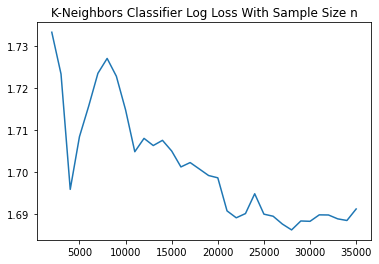

In [66]:
# Check approx where KNC error starts to plateau based on n instances for cutting off grid search and understanding training timing
plot_model_error_on_n(knc, 2000, 35000, "K-Neighbors Classifier")

In [90]:
knc_scores = cross_val_score(knc, x_train[:100000], y_train[:100000], cv=5, scoring = "neg_log_loss", n_jobs=4, verbose = 4)
print("The Basic kNeighbors Classifier Has a Neg Log Loss of: {}".format(round(knc_scores.mean(),3)))

The Basic kNeighbors Classifier Has a Neg Log Loss of: -1.691


### Grid Search K Neighbors Classifier

In [83]:
# Detail parameters for the K Neighbors Grid Search Below ### EXPAND THE GRID SEARCH
n_neighbors_params = [round(x) for x in np.linspace(100, 3000, 10)]
weights_params = ["uniform", "distance"]

In [85]:
knc_parameters = {'n_neighbors':n_neighbors_params, "weights":weights_params}

knc_grid_search = GridSearchCV(KNeighborsClassifier(), knc_parameters, cv=5, scoring = "neg_log_loss", verbose = 3, n_jobs=1)
knc_grid_search.fit(x_train[:20000], y_train[:20000])
clear_output(wait=False)

In [87]:
final_KNC_classifier = knc_grid_search.best_estimator_
print("The Best K Neighbors Classifier Has a Neg Log Loss Of: {}".format(round(knc_grid_search.best_score_.mean(), 3)))
print("The Best K Neighbors Classifier Has Parameters Of: {}".format(knc_grid_search.best_params_))

The Best K Neighbors Classifier Has a Neg Log Loss Of: -1.696
The Best K Neighbors Classifier Has Parameters Of: {'n_neighbors': 1389, 'weights': 'distance'}


In [89]:
# Because we grid searched for parameters on a smaller dataset, run the final estimator on a larger dataset for a best score
final_KNC_scores = cross_val_score(final_KNC_classifier, x_train[:150000], y_train[:150000], cv=5, scoring = "neg_log_loss", n_jobs=4, verbose=3)
clear_output(wait=False)
print("The Final K-Neighbors Classifier Has a Neg Log Loss of: {}".format(round(final_KNC_scores.mean(),3)))

The Final K-Neighbors Classifier Has a Neg Log Loss of: -1.687


## Random Forest Classifier

### Basic Random Forest Classifier

In [91]:
rf_classifier = RandomForestClassifier(random_state=42)

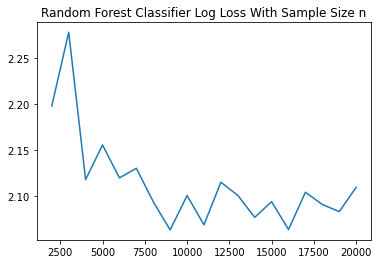

In [93]:
# Check approx where KNC error starts to plateau based on n instances for cutting off grid search and understanding training timing
plot_model_error_on_n(rf_classifier, 2000, 20000, "Random Forest Classifier")

In [94]:
# Test the basic Random Forest Classifier for use as a baseline
rf_scores = cross_val_score(rf_classifier, x_train[:50000], y_train[:50000], cv = 5, scoring = "neg_log_loss", verbose=4)
print("The Basic Random Forest Classifier Has a Neg Log Loss of: {}".format(round(rf_scores.mean(),3)))

The Basic Random Forest Classifier Has a Neg Log Loss of: -2.058


### Grid Search for Random Forest Classifier

In [112]:
# Detail parameters for the Random Forest Grid Search
estimators_params= [round(x) for x in np.linspace(600,2000,6)]
criterion_params = ["gini", "entropy", "log_loss"]
max_depth_params = [3, 4, 5]
min_sample_leaf_params = [round(x) for x in np.linspace(1,100,4)]

In [99]:
# Build a parameter grid for the Random Forest Classifier, and run the grid search
rf_parameters = {'n_estimators':estimators_params, "criterion":criterion_params, "max_depth":max_depth_params}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state = 42), rf_parameters, cv=5, scoring = "neg_log_loss", verbose = 3)
rf_grid_search.fit(x_train[:12000], y_train[:12000])
clear_output(wait=False)

In [103]:
# Print out grid search results
final_RF_regressor_plays = rf_grid_search_plays.best_estimator_
print("The Best Random Forest Classifier Has a Neg Log Loss Of: {}".format(round(rf_grid_search.best_score_.mean(), 3)))
print("The Best K Neighbors Classifier Has Parameters Of: {}".format(rf_grid_search.best_params_))

The Best Random Forest Classifier Has a Neg Log Loss Of: -1.662
The Best K Neighbors Classifier Has Parameters Of: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 600}


In [122]:
# Double check that a higher n_estimators is not warrented when using a larger sample size
boosted_estimator_rf_scores = cross_val_score(RandomForestClassifier(random_state=42, n_estimators=600, criterion="entropy", max_depth=11), x_train[:50000], y_train[:50000], cv=5, verbose=4, scoring="neg_log_loss", n_jobs=4)
clear_output(wait=False)
print("The Random Forest Classifier With Boosted Estimators Has a Neg Log Loss of: {}".format(round(boosted_estimator_rf_scores.mean(),3)))

The Random Forest Classifier With Boosted Estimators Has a Neg Log Loss of: -1.632


In [124]:
final_rf_classifier = RandomForestClassifier(random_state=42, n_estimators=600, criterion="entropy", max_depth=11)

## Histogram Based Gradient Boosting Classifier

Because of the testing limitations, we will also try a Histogram-based Gradient Boosting Classification Tree, which scales significantly better than the standard gradient boosting tree. It does not appear to support grid search however, so we will do that manually

In [126]:
hgb_classifier = HistGradientBoostingClassifier()

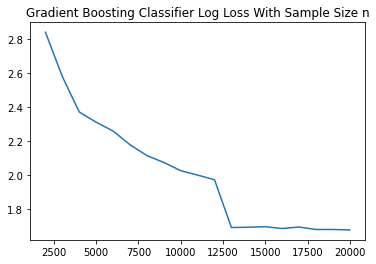

In [127]:
# Check approx where HGB Classifier error starts to plateau based on n instances for cutting off grid search and understanding training timing
plot_model_error_on_n(hgb_classifier, 2000, 20000, "Gradient Boosting Classifier")

In [130]:
hgb_classifier_scores = cross_val_score(hgb_classifier, x_train[:], y_train[:], cv=5, scoring="neg_log_loss", n_jobs = 4)
print("The Basic Hist Gradient Boosted Classifier Has a Neg Log Loss of: {}".format(round(hgb_classifier_scores.mean(),3)))

The Basic Hist Gradient Boosted Classifier Has a Neg Log Loss of: -1.615


In [148]:
iter_params = [100, 250, 500]
max_depth_params = [5, None]

all_param_lists = [iter_params, max_depth_params]

hgbc_param_list = list(itertools.product(*all_param_lists))

In [149]:
# Grid Search for the Plays Model
print("Grid Search For Plays")

best_score = -10000
best_params = {}
for tup in hgbc_param_list:
    print(tup)
    score = cross_val_score(HistGradientBoostingClassifier(max_iter=tup[0], max_depth = tup[1]), x_train[:], y_train[:], cv=5,
                                                          n_jobs = 4, scoring="neg_log_loss").mean()
    
    if score > best_score:
        best_score = score
        best_params = {"max_iter":tup[0], "max_depth":tup[1]}
                            
    clear_output(wait=False)

In [150]:
# Create a final HGB Classifier based on the results of the grid search and print the results
final_hgb_classifier = HistGradientBoostingClassifier(max_iter=best_params["max_iter"], max_depth = best_params["max_depth"])
print("The Best Histogram-Based Gradient Boosted Classifier Has a Neg Log Loss Of: {}".format(round(best_score, 3)))
print("The Best Histogram-Based Gradient Boosted Classifier Has Parameters Of: {}".format(best_params))

The Best Histogram-Based Gradient Boosted Classifier Has a Neg Log Loss Of: -1.593
The Best Histogram-Based Gradient Boosted Classifier Has Parameters Of: {'max_iter': 500, 'max_depth': 5}


In [158]:
# Because we grid searched for parameters on a smaller dataset, run the final estimator on a larger dataset for a best score
final_hgb_classifier_scores = cross_val_score(final_hgb_classifier, x_train[:], y_train[:], cv=5, scoring = "neg_log_loss", n_jobs=4, verbose=3)
clear_output(wait=False)
print("The Final Histogram Based Gradient Boosting Classifier Has a Neg Log Loss of: {}".format(round(final_hgb_classifier_scores.mean(),3)))

The Final Histogram Based Gradient Boosting Classifier Has a Neg Log Loss of: -1.595


## ADA Boost Classifier

### Basic ADA Boost Classifier

In [159]:
abc = AdaBoostClassifier()

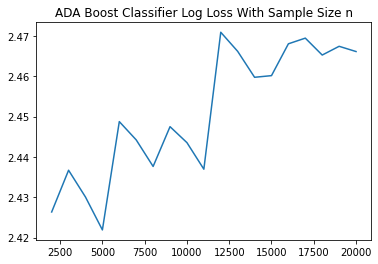

In [160]:
# Check approx where ADA Boost Classifier error starts to plateau based on n instances for cutting off grid search and understanding training timing
plot_model_error_on_n(abc, 2000, 20000, "ADA Boost Classifier")

In [163]:
# Test the Basic ADA Boost Classifier to get a baseline score
abc_scores = cross_val_score(abc, x_train[:], y_train[:], cv=5, scoring="neg_log_loss", n_jobs = 4)
print("The Basic ADA Boost Classifier Has a Neg Log Loss of: {}".format(round(abc_scores.mean(),3)))

The Basic ADA Boost Classifier Has a Neg Log Loss of: -2.447


### Grid Search for ADA Boost Classifier

In [179]:
# Build a parameter grid for searching with the ADA Boost Classifier
weak_learner_params = [DecisionTreeClassifier(max_depth=x) for x in [1,2,None]]+ [LogisticRegression()]
n_estimators_params = [8, 10, 12, 20]

In [180]:
# Run the grid search for the ADA Boost Classifier
abc_parameters = {'n_estimators':n_estimators_params, "base_estimator":weak_learner_params}
abc_grid_search = GridSearchCV(AdaBoostClassifier(), abc_parameters, cv=5, scoring = "neg_log_loss", verbose = 3)
abc_grid_search.fit(x_train[:30000], y_train[:30000])
clear_output(wait=False)

In [190]:
# Print grid search results for the ADA Boost Classifier
final_abc_classifier = abc_grid_search.best_estimator_
print("The Best Ada Boost Classifier Has a Neg Log Loss Of: {}".format(round(abc_grid_search.best_score_, 3)))
print("The Best Ada Boost Classifier Has Parameters Of: {}".format(abc_grid_search.best_params_))

The Best Ada Boost Classifier Has a Neg Log Loss Of: -2.149
The Best Ada Boost Classifier Has Parameters Of: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'n_estimators': 8}


In [192]:
# Because the grid search was run on a smaller sample, test the best grid search model on a larger sample
final_abc_scores = cross_val_score(final_abc_classifier, x_train[:], y_train[:], cv=5, scoring = "neg_log_loss", n_jobs=4, verbose=3)
clear_output(wait=False)
print("The ADA Boost Classifier Has a Neg Log Loss of: {}".format(round(final_abc_scores.mean(),3)))

The ADA Boost Classifier Has a Neg Log Loss of: -2.191


## XGBoost Classifier

In [193]:
y_train_encoded = OrdinalEncoder().fit_transform(np.array(y_train).reshape(-1,1))
y_train_encoded = [int(x[0]) for x in y_train_encoded]

### Basic XGBoost Classifier

In [194]:
# Set up the base XGBoost Classifier
xgb = XGBClassifier()

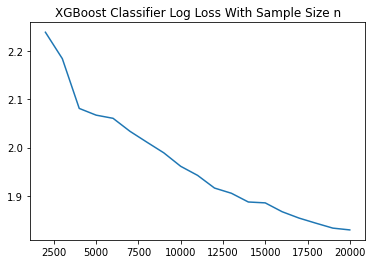

In [198]:
# Check approx where XGBoost Classifier error starts to plateau based on n instances for cutting off grid search and understanding training timing
plot_model_error_on_n(xgb, 2000, 20000, "XGBoost Classifier", y_train=y_train_encoded)

In [199]:
# Check the baseline
xgb_scores = cross_val_score(xgb, x_train, y_train_encoded, cv=5, scoring="neg_log_loss", n_jobs=4, verbose = 3)
print("The Basic XGBoost Boost Classifier Has a Neg Log Loss of: {}".format(round(xgb_scores.mean(),3)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.0min


The Basic XGBoost Boost Classifier Has a Neg Log Loss of: -1.606


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.1min finished


### Grid Search for XGBoostClassifier

In [203]:
child_weight_params = [1, 3, 6]
gamma_params = [.5, 1, 1.5]
subsample_params = [.6, .8]
colsample_bytree_params = [.6, .8]
max_depth_params = [1,2,5]
alpha_params = [.5, 1]

In [204]:
xgb_params = {'min_child_weight': child_weight_params,'gamma': gamma_params,'subsample': subsample_params,
              'colsample_bytree': colsample_bytree_params,'max_depth': max_depth_params, "alpha":alpha_params}

xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_params, cv=5, scoring = "neg_log_loss", verbose = 3)
xgb_grid_search.fit(x_train[:30000], y_train_encoded[:30000])
clear_output(wait=False)

In [205]:
final_xgb = xgb_grid_search.best_estimator_
print("The Best XGBoost Classifier Has a Neg Log Loss Of: {}".format(round(xgb_grid_search.best_score_, 3)))
print("The Best XABoost Classifier Has Parameters Of: {}".format(xgb_grid_search.best_params_))

The Best XGBoost Classifier Has a Neg Log Loss Of: -1.608
The Best XABoost Classifier Has Parameters Of: {'alpha': 0.5, 'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.8}


In [208]:
final_xgb_scores = cross_val_score(xgb_grid_search.best_estimator_, x_train, y_train_encoded, cv=5, scoring="neg_log_loss", verbose=3, n_jobs=4)
print("The Final XGBoost Classifier Has a Neg Log Loss Of: {}".format(round(final_xgb_scores.mean(), 3)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   49.0s remaining:  1.2min


The Final XGBoost Classifier Has a Neg Log Loss Of: -1.61


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.2min finished


## Neural Network

In [211]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [355]:
def run_neural_network(list_nodes, features=126, categories=13, x_train=x_train, y_train=y_train_encoded):
    callback = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_crossentropy', patience=5, start_from_epoch=4, restore_best_weights = True)

    # Create a Sequential model
    model = Sequential()

    # Add the first hidden layer with 10 nodes and specify the input shape (54 inputs)
    model.add(Dense(list_nodes[0], input_shape=(features,), activation='relu'))
    
    for layer in range(len(list_nodes)-1):
        # Add the second hidden layer with 10 nodes
        model.add(Dense(list_nodes[layer+1], activation='relu'))

    # Add the output layer with 13 nodes 
    model.add(Dense(categories, activation='softmax'))

    # Call model on a test input
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_crossentropy'])
    # fit the keras model on the dataset
    model_history = model.fit(x_train, np.array(y_train_encoded), epochs=150, batch_size=10, callbacks = [callback])
    
    return {"final_model":model, "model_history":model_history} 


### Grid Search Neural Network Layers

In [356]:
models = []
scores = []

best_model = None
best_score = 10000

In [359]:
for n in range(30):
    print("Running NN Number {}".format(n+1))
    
    layers1 = np.random.randint(100,size=np.random.randint(4,size = 1)[0]+1)
    layers2 = [layers1[0] for n in layers1]
    
    current_score = 100000
    
    model1 = run_neural_network(layers1)
    models.append([layer.output_shape[1] for layer in model1["final_model"].layers])
    scores.append(min(model1["model_history"].history["loss"]))
    
    if min(model1["model_history"].history["loss"]) < best_score:
        best_score = scores[-1]
        best_model = models[-1]
        
    print("\n\n\n Running Even Layered NN Number {}".format(n+1))
    model2 = run_neural_network(layers2)
    models.append([layer.output_shape[1] for layer in model2["final_model"].layers])
    scores.append(min(model2["model_history"].history["loss"]))
    
    if min(model2["model_history"].history["loss"]) < best_score:
        best_score = scores[-1]
        best_model = models[-1]  
        
clear_output(wait=False)

In [424]:
model_summary = {"Baseline Guesser":{"Model":None, "Score":dumb_log_loss_plays},
                 "Logistic Regression":{"Model":final_logistic_regressor, "Score":round(final_softmax_scores.mean(),3)},
                 "K-Neighbors":{"Model":final_KNC_classifier, "Score":round(final_KNC_scores.mean(),3)},
                 "Random Forest":{"Model":final_rf_classifier, "Score":round(boosted_estimator_rf_scores.mean(),3)},
                 "Gradient Boosting":{"Model":final_hgb_classifier, "Score":round(final_hgb_classifier_scores.mean(),3)},
                 "ADA Boost":{"Model":final_abc_classifier, "Score":round(final_abc_scores.mean(),3)},
                 "XGBoost":{"Model":final_xgb, "Score":round(final_xgb_scores.mean(),3)},
                 "Neural Network":{"Model":best_model, "Score":-best_score}}

summary_df = pd.DataFrame({"Models":model_summary.keys(), "Scores":[round(model_summary[key]["Score"]*-1,2) for key in model_summary]})
summary_df = summary_df.sort_values(by='Scores', ascending=False).reset_index()

Text(0.5, 1.0, 'Final Log Loss by Model')

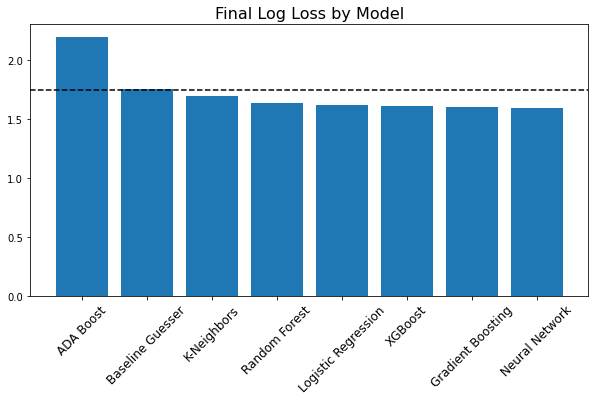

In [425]:
plt.figure(figsize = (10,5))
plt.bar(summary_df.Models, summary_df.Scores)
plt.xticks(rotation=45)
plt.xticks(fontsize = 12)
plt.axhline(y = -model_summary["Baseline Guesser"]["Score"], color = 'k', linestyle = 'dashed')     
plt.title("Final Log Loss by Model", fontsize=16)

In [432]:
pkl.dump(model_summary, open("Summary of Models.pkl", "wb"))

In [433]:
models = pkl.load(open("Summary of Models.pkl", "rb"))